## Predicting Movie Reviews with Classification Learning Models 

Data: **IMDB Dataset of 50K Movie Reviews**

Written Report: https://docs.google.com/document/d/1U9AlaiB18F-da0DgK1KsW6pISuzzGhL_s1Oan3xAQGg/edit

*This file contains all programming done by Joshua Susanto*

In [6]:
# Import necessary packages
import numpy as np
import pandas as pd
import sklearn
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import numpy.linalg as la
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Exploratory Analysis

In [7]:
# Read dataset
full_data = pd.read_csv('IMDB Dataset.csv')
full_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [345]:
# Positice Sentiment Lexicon
file = open("positive-words.txt", "r")
pos_words = file.read()
file.close()

pos_words = pos_words.splitlines()
pos_words = pos_words[1:]
pos_words[0:20]

['a+',
 'abound',
 'abounds',
 'abundance',
 'abundant',
 'accessable',
 'accessible',
 'acclaim',
 'acclaimed',
 'acclamation',
 'accolade',
 'accolades',
 'accommodative',
 'accomodative',
 'accomplish',
 'accomplished',
 'accomplishment',
 'accomplishments',
 'accurate',
 'accurately']

In [347]:
# Negative Sentiment Lexicon
file = open("negative-words.txt", "r")
neg_words = file.read()
file.close()

neg_words = neg_words.splitlines()
neg_words = neg_words[1:]
neg_words[0:20]

['2-faced',
 '2-faces',
 'abnormal',
 'abolish',
 'abominable',
 'abominably',
 'abominate',
 'abomination',
 'abort',
 'aborted',
 'aborts',
 'abrade',
 'abrasive',
 'abrupt',
 'abruptly',
 'abscond',
 'absence',
 'absent-minded',
 'absentee',
 'absurd']

In [349]:
full_data['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [350]:
# First document
full_data['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

## Preprocessing

Lots of things to clean:
- capitalization
- normalization of words
- punctuation
- line break errors
- stop words

TF-IDF will do most of these things implicitly, but must do some of these steps manually to check the initial distribution of words for the sake of exploratory analysis.

In [351]:
# removing line break errors
full_data['review'] = full_data['review'].apply(lambda x:re.sub('br', '', x))
full_data['review'] = full_data['review'].apply(lambda x:re.sub('/', '', x))
full_data['review'] = full_data['review'].apply(lambda x:re.sub('>', '', x))
full_data['review'] = full_data['review'].apply(lambda x:re.sub('<', '', x))

# lowercase
full_data['review'] = full_data['review'].apply(lambda x:x.lower())

full_data['review'][0]

"one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. they are right, as this is exactly what happened with me.  the first thing that struck me about oz was its utality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word.  it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.  i would say the main appeal of the show is due to the fact that it goes where other show

In [352]:
# tokenize data
full_data['tokenized'] = full_data['review'].apply(lambda x:word_tokenize(x))
print(full_data['tokenized'][0])

['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', '1', 'oz', 'episode', 'you', "'ll", 'be', 'hooked', '.', 'they', 'are', 'right', ',', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'me', '.', 'the', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'utality', 'and', 'unflinching', 'scenes', 'of', 'violence', ',', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go', '.', 'trust', 'me', ',', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'timid', '.', 'this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', ',', 'sex', 'or', 'violence', '.', 'its', 'is', 'hardcore', ',', 'in', 'the', 'classic', 'use', 'of', 'the', 'word', '.', 'it', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'oswald', 'maximum', 'security', 'state', 'penitentary', '.', 'it', 'focuses', 'mainly', 'on', 'emerald', 'city', ',', 'an', 'experimental',

In [353]:
# set stop words, using first article as a test
stop_words = set(stopwords.words('english'))

# lowecase removal example
full_data['tokenized'][0] = [w.lower() for w in full_data['tokenized'][0]]

# removing stopwords, example with the first review
full_data['tokenized'][0] = [w for w in full_data['tokenized'][0] if not w in stop_words] 
full_data['tokenized'][0] = [w for w in full_data['tokenized'][0] if not w =='.']
full_data['tokenized'][0] = [w for w in full_data['tokenized'][0] if not w == ',']
full_data['tokenized'][0] = [w for w in full_data['tokenized'][0] if not w == "n't"]
full_data['tokenized'][0] = [w for w in full_data['tokenized'][0] if not w == "'ll"]

# stemming example
porter = nltk.PorterStemmer()
full_data['tokenized'][0]  = [porter.stem(w) for w in full_data['tokenized'][0]]

print(full_data['tokenized'][0])

['one', 'review', 'mention', 'watch', '1', 'oz', 'episod', 'hook', 'right', 'exactli', 'happen', 'first', 'thing', 'struck', 'oz', 'utal', 'unflinch', 'scene', 'violenc', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'heart', 'timid', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violenc', 'hardcor', 'classic', 'use', 'word', 'call', 'oz', 'nicknam', 'given', 'oswald', 'maximum', 'secur', 'state', 'penitentari', 'focus', 'mainli', 'emerald', 'citi', 'experiment', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inward', 'privaci', 'high', 'agenda', 'em', 'citi', 'home', 'mani', '..', 'aryan', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', '....', 'scuffl', 'death', 'stare', 'dodgi', 'deal', 'shadi', 'agreement', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goe', 'show', 'would', 'dare', 'forget', 'pretti', 'pictur', 'paint', 'mainstream', 'audienc', 'forget', 'charm', 'forget', 'romanc', '...', 'oz', 'mess', 'a

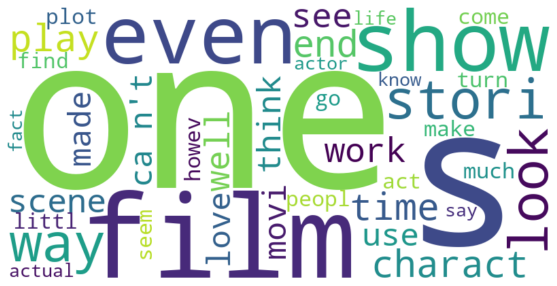

In [354]:
# join all text
all_text = " ".join(full_data['review'].astype(str))

# tokenize all text
all_text_tokenized = word_tokenize(all_text)

# remove stop words
filtered_tokens = [word for word in all_text_tokenized if word not in stop_words]

# stem words
porter = nltk.PorterStemmer()
filtered_tokens  = [porter.stem(x) for x in filtered_tokens]

# join the filtered tokens into a single string
filtered_text = " ".join(filtered_tokens)

# wordcloud generation
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color = "white").generate(filtered_text)

# plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### General TF-IDF Dictionary

In [411]:
# TF-IDF
vectorizer = TfidfVectorizer(max_features = 2000, stop_words='english') # max features: max_number of keywords to consider.
X = vectorizer.fit_transform(full_data['review']) # tf-idf conversion
feature_names = vectorizer.get_feature_names() # top 2000 terms (dictionary)
print(X.shape)

(50000, 2000)


In [412]:
print(X)

  (0, 1808)	0.10252703711101174
  (0, 1775)	0.1105697221561603
  (0, 1892)	0.09321004143019412
  (0, 595)	0.08582041756149543
  (0, 1607)	0.11541693374580107
  (0, 1688)	0.09798807337084531
  (0, 990)	0.08681388433929843
  (0, 1835)	0.08851194271941382
  (0, 301)	0.09222141276510981
  (0, 1141)	0.0887817096832035
  (0, 1252)	0.08879352031493697
  (0, 974)	0.08556685560749269
  (0, 777)	0.11705801996451702
  (0, 1027)	0.11603948282689776
  (0, 771)	0.06384640747985053
  (0, 1749)	0.10397049761169333
  (0, 453)	0.10593216675935946
  (0, 1925)	0.07163880760069201
  (0, 1419)	0.10838053436424794
  (0, 372)	0.07911781832070525
  (0, 1732)	0.1183821195629724
  (0, 1194)	0.10972503731485306
  (0, 1513)	0.06528398706379836
  (0, 1136)	0.09688550710532583
  (0, 488)	0.059981290839883475
  :	:
  (49999, 1020)	0.13294050430526158
  (49999, 1855)	0.14809008397096168
  (49999, 986)	0.15460034029785846
  (49999, 1510)	0.15694484632625766
  (49999, 265)	0.15597015171297327
  (49999, 1828)	0.130711969

In [413]:
print(feature_names[1:200])

['10', '100', '1010', '11', '12', '13', '15', '20', '30', '40', '50', '60', '70', '70s', '80', '80s', '810', '90', 'ability', 'able', 'absolute', 'absolutely', 'absurd', 'academy', 'accent', 'accept', 'accident', 'according', 'accurate', 'act', 'acted', 'acting', 'action', 'actions', 'actor', 'actors', 'actress', 'actresses', 'acts', 'actual', 'actually', 'adam', 'adaptation', 'add', 'added', 'addition', 'adds', 'admit', 'adult', 'adults', 'adventure', 'advice', 'affair', 'afraid', 'african', 'age', 'aged', 'agent', 'ages', 'ago', 'agree', 'ahead', 'ain', 'air', 'al', 'alan', 'alex', 'alice', 'alien', 'aliens', 'alive', 'allen', 'allow', 'allowed', 'allows', 'amazing', 'america', 'american', 'americans', 'amusing', 'ancient', 'andy', 'angel', 'angry', 'animal', 'animals', 'animated', 'animation', 'ann', 'anna', 'anne', 'annoying', 'answer', 'anthony', 'anti', 'anybody', 'anymore', 'apart', 'apartment', 'apparent', 'apparently', 'appeal', 'appear', 'appearance', 'appeared', 'appears', '

In [359]:
# (don't run this lol) export tf-idf matrix as a file

dense_tfidf = X.toarray()

# combine matrix w/ original dataset
data_with_tfidf = df_with_tfidf = pd.concat([full_data, pd.DataFrame(dense_tfidf, columns = feature_names)], axis=1)

# csv export
data_with_tfidf.to_csv('tfidf_data.csv', index=False)

In [415]:
# print a subset, this data is sparse which is helpful
print(dense_tfidf[:10, :10])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.10802464 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.20267966 0.         0.        ]
 [0.         0.11515601 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.

there are two different methods to consider:


- finding the tf-idf dictionary on the general dataset, obtaining the 2000 highest tfidf words as the predictors
- considering words from a premade dictionary, we calculate the tf-idfs for the positive negative sentiment lexicon to build our model

### Sentiment Lexicon TF-IDF Dictionary

In [381]:
# combine both positive and negative words into a single list
all_lex = pos_words + neg_words
print(len(all_lex))

# create combined dictionary
lex_dict = {index: key for index, key in enumerate(all_lex)}

6789


In [380]:
# TF-IDF
terms = set(list(lex_dict.values())) # obtain all unique values
vectorizer = TfidfVectorizer(stop_words = 'english', vocabulary = terms) 
X_lex = vectorizer.fit_transform(full_data['review']) # tf-idf conversion
feature_names_lex = vectorizer.get_feature_names() 
print(X_lex.shape) # 3 common terms between the positive and negative lexicon

(50000, 6786)


In [418]:
# converting to dense array
dense_lex = X_lex.toarray()
print(dense_lex.sum(axis=0, dtype='float'))

[  0.           0.           0.         ...   6.28005141   3.81024337
 197.49939983]


In [419]:
print(dense_lex.shape)

(50000, 6786)


In [423]:
# (don't run this lol) export lexicon tf-idf matrix as a file

# combine matrix w/ original dataset
data_with_tfidf_lex =  pd.concat([full_data, pd.DataFrame(dense_lex, columns = feature_names_lex)], axis=1)

# csv export
data_with_tfidf_lex.to_csv('tfidf_data_lexicon.csv', index=False)

## Logistic Regression (No Dimensional Reduction)

### General TF-IDF

In [424]:
# convert labels into numeric
label_mapping = {'positive': 1, 'negative': 0}
full_data['y'] = [label_mapping[i] for i in full_data['sentiment']]
print(full_data['y'].head(),'\n',full_data['sentiment'].head())

# train test split
X_train, X_test, y_train, y_test = train_test_split(dense_tfidf, full_data['y'], test_size = 0.5, random_state = 42)

# check split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

0    1
1    1
2    1
3    0
4    1
Name: y, dtype: int64 
 0    positive
1    positive
2    positive
3    negative
4    positive
Name: sentiment, dtype: object
(25000, 2000) (25000, 2000) (25000,) (25000,)


In [425]:
# initialize model
model = LogisticRegression()

# fit logistic regression model
model.fit(X_train, y_train)

# predict testing data
y_pred = model.predict(X_test)

# model accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8736
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12483
           1       0.86      0.89      0.88     12517

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



### Sentiment Lexicon TF-IDF

In [388]:
# train test split
X_lex_train, X_lex_test, y_lex_train, y_lex_test = train_test_split(dense_lex, full_data['y'], test_size = 0.5, random_state = 42)

# check split
print(X_lex_train.shape, X_lex_test.shape, y_lex_train.shape, y_lex_test.shape)

(25000, 6786) (25000, 6786) (25000,) (25000,)


In [441]:
# initialize model
model = LogisticRegression()

# fit logistic regression model
model.fit(X_lex_train, y_lex_train)

# predict testing data
y_lex_pred = model.predict(X_lex_test)

# model accuracy
accuracy = accuracy_score(y_lex_test, y_lex_pred)
print(f"Accuracy: {accuracy}")

print("Classification Report:")
print(classification_report(y_lex_test, y_lex_pred))

Accuracy: 0.8544
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     12483
           1       0.84      0.87      0.86     12517

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



We see a fairly strong testing accuracy with both of our logistic regression model. There are many other models to consider, each with potentially varying dergees of success, including using dimensionality reduction techniques:
- KNN 
- Random Forests
- LDA and QDA
- Logistic Regression (with PCA)

## Principal Component Analysis

### PCA with our general matrix

In [426]:
# import PCA and SVD
U,S,VT = np.linalg.svd(X_train, full_matrices=False)
U_test,S_test,VT_test = np.linalg.svd(X_test, full_matrices=False)

In [427]:
print(U.shape, S.shape, VT.shape)

(25000, 2000) (2000,) (2000, 2000)


In [428]:
print(U_test.shape, S_test.shape, VT_test.shape)

(25000, 2000) (2000,) (2000, 2000)


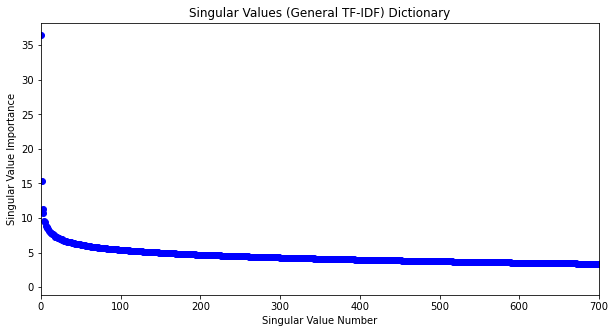

In [451]:
plt.figure(figsize=(10, 5))
plt.plot(S,'bo')
plt.title('Singular Values (General TF-IDF) Dictionary')
plt.ylabel("Singular Value Importance")
plt.xlabel("Singular Value Number")
ax = plt.gca()
ax.set_xlim([0, 700])
plt.show()

In [430]:
# checking our SVs
S[0:20]

array([36.42387667, 15.3931341 , 11.31848546, 10.68512856,  9.52027181,
        9.38133469,  8.84053997,  8.75790535,  8.51124784,  8.3460202 ,
        8.09567511,  7.99767251,  7.89324196,  7.82994814,  7.73215981,
        7.63076213,  7.53947699,  7.40590034,  7.32775534,  7.28666889])

In [431]:
variance = []
for i in range(0,2001):
    variance.append(np.sum(S[0:i]**2)/np.sum(S**2))
print(variance[1:10])

[0.05306795165992505, 0.06254589475420666, 0.0676702192815992, 0.07223709817402243, 0.07586252118863535, 0.0793828988112064, 0.08250910468967168, 0.08557714093205328, 0.08847479452678077]


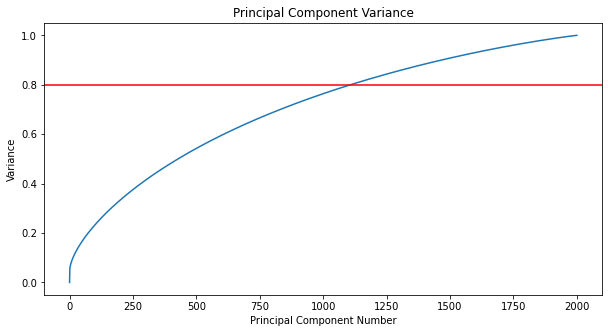

In [432]:
plt.figure(figsize=(10, 5))
plt.plot(variance)
plt.axhline(y = 0.8, color='r', linestyle='-')
plt.title('Principal Component Variance')
plt.ylabel("Variance")
plt.xlabel("Principal Component Number")
plt.show()

### PCA with our Sentiment Lexicon Matrix

In [ ]:
# run PCA
U_lex,S_lex,VT_lex = np.linalg.svd(dense_lex, full_matrices=False)
# U_lex_test,S_lex_test,VT_lex_test = np.linalg.svd(X_lex_test, full_matrices=False)

In [2]:
# check dimensions
print(U_lex.shape, S_lex.shape, VT_lex.shape)

NameError: name 'U_lex' is not defined

In [3]:
print(U_lex_test.shape, S_lex_test.shape, VT_lex_test.shape)

NameError: name 'U_lex_test' is not defined

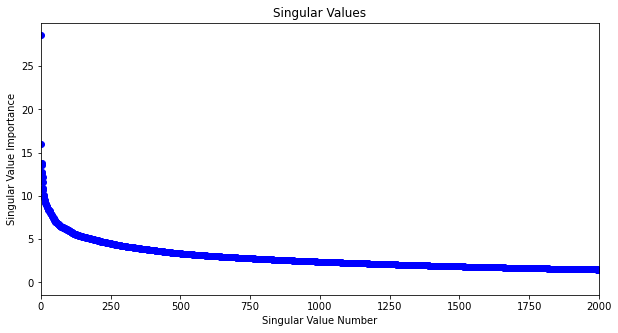

In [405]:
# plot the singular values
plt.figure(figsize=(10, 5))
plt.plot(S_lex,'bo')
plt.title('Singular Values')
plt.ylabel("Singular Value Importance")
plt.xlabel("Singular Value Number")
ax = plt.gca()
ax.set_xlim([0, 2000])
plt.show()

In [407]:
variance_lex = []
for i in range(0,6787):
    variance_lex.append(np.sum(S_lex[0:i]**2)/np.sum(S_lex**2))
print(variance_lex[1:10])

[0.03264200774127978, 0.04289946579574402, 0.050558218366440845, 0.057933469216088024, 0.06441031010971274, 0.07082181166980094, 0.07672878733686213, 0.08213402891455343, 0.08686880897381234]


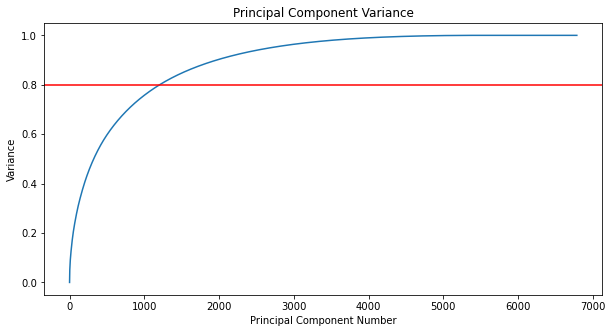

In [410]:
# plot the cumulative variance
plt.figure(figsize=(10, 5))
plt.plot(variance_lex)
plt.axhline(y = 0.8, color='r', linestyle='-')
plt.title('Principal Component Variance')
plt.ylabel("Variance")
plt.xlabel("Principal Component Number")
plt.show()

## Logistic Regression (with reduced dimensions)

From our PCA analysis we see that in terms of explained variance, around 80% of it can be accounted for with around the first 1100 principal components, for both matrices conveniently. This would mean we would need to reduce our dimension by about 900 and 5600 respectively. Taking these principal components we can now perform logistic regression with reduced dimensions.

In [219]:
# taking the first 1100 PCs 
X_PCA = X_train@VT[0:1100,:].T
X_PCA.shape 

(25000, 1100)

In [434]:
X_lex_PCA = X_lex_train@VT_lex[0:1100,:].T
X_lex_PCA.shape 

(25000, 1100)

In [435]:
# taking the first 1100 PCs for testing data
X_PCA_test = X_test@VT_test[0:1100,:].T
X_PCA_test.shape

(25000, 1100)

In [436]:
X_lex_PCA_test = X_lex_test@VT_lex_test[0:1100,:].T
X_lex_PCA_test.shape

(25000, 1100)

In [437]:
# initialize model
model = LogisticRegression()

# fit logistic regression model
model.fit(X_PCA, y_train)

# predict testing data
y_pred = model.predict(X_PCA_test)

# model accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.75232
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75     12483
           1       0.76      0.75      0.75     12517

    accuracy                           0.75     25000
   macro avg       0.75      0.75      0.75     25000
weighted avg       0.75      0.75      0.75     25000



In [442]:
# initialize model
model = LogisticRegression()

# fit logistic regression model
model.fit(X_lex_PCA, y_lex_train)

# predict testing data
y_lex_pred = model.predict(X_lex_PCA_test)

# model accuracy
accuracy = accuracy_score(y_lex_test, y_lex_pred)
print(f"Accuracy: {accuracy}")

print("Classification Report:")
print(classification_report(y_lex_test, y_lex_pred))

Accuracy: 0.384
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.44      0.42     12483
           1       0.37      0.33      0.35     12517

    accuracy                           0.38     25000
   macro avg       0.38      0.38      0.38     25000
weighted avg       0.38      0.38      0.38     25000



Obviously, we can't stop a certain amount of information from being loss byh reducing the dimensionality of our data. However, with our reduction we were able to still get a relatively strong testing accuracy and cut our computaional time significantly. Since the data is sparse enough to run a normal logistic regression without any dimensional reduction, a normal logistic regression is still a better model. However, this is a good practice to observe the tradeoff between information loss and computational efficiency.

### [IGNORE] Data Writing and Export

In [229]:
# export reduced train and test data

# train 
df_train_pca = pd.DataFrame(X_PCA)
df_train_pca.to_csv('xtrain_pca.csv', index=False)

# test 
df_test_pca = pd.DataFrame(X_PCA_test)
df_test_pca.to_csv('xtest_pca.csv', index=False)

In [447]:
# export sentiment lexicon reduced train and test data

# train 
df_train_lex_pca = pd.DataFrame(X_lex_PCA)
df_train_lex_pca.to_csv('xtrain_lex_pca.csv', index=False)

# test 
df_test_lex_pca = pd.DataFrame(X_lex_PCA_test)
df_test_lex_pca.to_csv('xtest_lex_pca.csv', index=False)

In [232]:
# exporting labels

# train 
df_train_labels = pd.DataFrame(y_train)
df_train_labels.to_csv('y_train', index=False)

# test
df_test_labels = pd.DataFrame(y_test)
df_test_labels.to_csv('y_test', index=False)

In [448]:
# exporting labels for sentiment lexicon data

# train 
df_train_lex_labels = pd.DataFrame(y_lex_train)
df_train_lex_labels.to_csv('y_lex_train', index=False)

# test
df_test_lex_labels = pd.DataFrame(y_lex_test)
df_test_lex_labels.to_csv('y_lex_test', index=False)

## K-Nearest Neighbors

### General Data

In [446]:
# choosing k = sqrt(N) which is about 157
k_neighbors = 157

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_model.fit(X_PCA, y_train)

# Predictions and evaluation for KNN
knn_predictions = knn_model.predict(X_PCA_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)

print("k-Nearest Neighbors:")
print(f"Accuracy: {knn_accuracy}")
print("Classification Report:")
print(classification_report(y_test, knn_predictions))

k-Nearest Neighbors:
Accuracy: 0.63844
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.32      0.47     12483
           1       0.58      0.96      0.73     12517

    accuracy                           0.64     25000
   macro avg       0.74      0.64      0.60     25000
weighted avg       0.74      0.64      0.60     25000



In [450]:
# reduced k but using full data
k_neighbors = 50

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_model.fit(X_train, y_train)

# Predictions and evaluation for KNN
knn_predictions = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)

print("k-Nearest Neighbors:")
print(f"Accuracy: {knn_accuracy}")
print("Classification Report:")
print(classification_report(y_test, knn_predictions))

k-Nearest Neighbors:
Accuracy: 0.78108
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77     12483
           1       0.77      0.81      0.79     12517

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78     25000



### Sentiment Lexicon Data

In [449]:
# choosing k = sqrt(N) which is about 157
k_neighbors = 157

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_model.fit(X_lex_PCA, y_lex_train)

# Predictions and evaluation for KNN
knn_predictions = knn_model.predict(X_lex_PCA_test)
knn_accuracy = accuracy_score(y_lex_test, knn_predictions)

print("k-Nearest Neighbors:")
print(f"Accuracy: {knn_accuracy}")
print("Classification Report:")
print(classification_report(y_lex_test, knn_predictions))

k-Nearest Neighbors:
Accuracy: 0.47248
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.01      0.02     12483
           1       0.49      0.93      0.64     12517

    accuracy                           0.47     25000
   macro avg       0.30      0.47      0.33     25000
weighted avg       0.30      0.47      0.33     25000



## K-fold Cross Validation

In [453]:
from sklearn.model_selection import cross_val_score

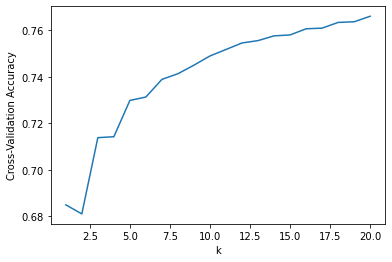

In [456]:
# Example of cross-validation for k values from 1 to 20
k_values = list(range(1, 21))
cv_scores = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, dense_tfidf, full_data['y'], cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot the results to visualize performance vs. k

plt.plot(k_values, cv_scores)
plt.xlabel('k')
plt.ylabel('Cross-Validation Accuracy')
plt.show()